# Local likelihood optimization

In the previous notebook, we went through the calculation of the likelihood function for an HMM and explicitly minimized it. Specifically, we looked at a situation where the transition rate and emission probability matrices took the form

$$ \boldsymbol{A} = \left[ \begin{matrix} 1 - a & a \\ a & 1 - a \end{matrix} \right] $$

and 

$$ \boldsymbol{B} = \left[ \begin{matrix} 1 - b & b \\ b & 1 - b \end{matrix} \right] $$

respectively, then we estimated the parameters $a$ and $b$ given a known sequence of observed and hidden states.

In a more general setting we will not known, *a priori* what the hidden state sequence was (it is hidden, after all...) So, to deal with this we would need to calculate the likelihood over all possible hidden state sequences, and all parameter values in the $A$ and $B$ matrices. This problem will quickly become very high dimensional, and as a result we must resort to other methods. Specifically, we can perform a local optimization routine on the parameter space, for a given initial starting point.

Specifically, we will first build a custom gradient descent algorithm to track the evolution of the parameter vector over iterations, and then use these results to validate a more efficient implementation using a `scipy.optimize.minimize` function to do the heavy lifting.

#### Gradient descent

Given that we are trying to minimize the likelihood function $\mathcal{L}(\theta)$, for parameter vector $\theta$, the general form of a gradient descent algorithm will update the value of the parameter vector $\theta_i \to \theta_{i+1}$ as

$$ \theta_{i+1} = \theta_i - \eta \nabla \mathcal{L}(\theta_i) $$

where $\nabla$ is the gradient of the likelihood function and $\eta$ is the *learning rate* which determines how large the update steps are. For an initial implementation, we take the learning rate to be constant, but there are many schemes that optimize this parameter by dynamically updating it so that the solution converges towards a local minimum more rapidly.  In order to calculate the derivative of the likelhood function, we will use a simple first-order difference in the likelihood function, approximating each component of the gradient with a simple first-difference

$$ \partial_{\theta^k}\mathcal{L}(\theta_i) \approx \frac{1}{2 \Delta\theta^{k}} \left[ \mathcal{L}(\theta + \Delta\theta^{k}) - \mathcal{L}(\theta - \Delta\theta^{k}) \right] $$

where $\Delta\theta^k$ is chosen to be small.  This procedure requires two evaluations of the likelihood function for each iterative update to the parameter vector.


In [1]:
# First, import the necessary packages and generate a the dynamics of an example HMM
import os
import numpy as np
from typing import Iterable, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', palette="hls")

# Import HMM libraries
from hidden import dynamics
from hidden import infer
from pathlib import Path

# here we assume the dynamics are symmetric
a = 0.3
b = 0.2

A = np.array([[1 - a, a], [a, 1 - a]])
B = np.array([[1 - b, b], [b, 1 - b]])

hmm = dynamics.HMM(2, 2)

In [2]:
# Initialize the Dynamics and Observation matrices
hmm.initialize_dynamics(A, B)

# Now run the dynamics for 500 steps
hmm.run_dynamics(1000)
state_ts = hmm.get_state_ts()
obs_ts = hmm.get_obs_ts()

In [12]:
def calc_likelihood(
    B: np.ndarray,
    bayes_pred: Iterable[np.ndarray],
    obs_ts: Iterable[int]
) -> float:
    likelihood = 0
    for bayes, obs in zip(bayes_pred, obs_ts):
        inner =  bayes @ B[:, obs]
        likelihood -= np.log(inner)
    return likelihood

In [13]:

def _build_hmm_parameters(theta: np.ndarray) -> Tuple:
    # Based on convention of what the parameters are, this function will return
    # the A and B matrices based on the input parameter vector
    # Here it is assumed that theta = (a, b)
    A = theta[0] * np.ones((2, 2))
    B = theta[1] * np.ones((2, 2))

    A[0, 0], A[1, 1] = 1 - theta[0], 1 - theta[0]
    B[0, 0], B[1, 1] = 1 - theta[1], 1 - theta[1]

    return A, B


def _get_likelihood_deriv(
    curr_theta: np.ndarray,
    obs_ts: np.ndarray,
    est: infer.MarkovInfer,
    delta: Optional[float] = 0.01
) -> np.ndarray:

    grad = np.zeros_like(curr_theta)

    for i in range(len(curr_theta)):
        plus_theta = np.copy(curr_theta)
        minus_theta = np.copy(curr_theta)

        plus_theta[i] += delta
        minus_theta[i] -= delta

        A_plus, B_plus = _build_hmm_parameters(plus_theta)
        A_minus, B_minus = _build_hmm_parameters(minus_theta)

        est.forward_algo(obs_ts, A_plus, B_plus, prediction_tracker=True)
        bayes_plus = np.copy(est.predictions)
        est.forward_algo(obs_ts, A_minus, B_minus, prediction_tracker=True)
        bayes_minus = np.copy(est.predictions)

        likelihood_plus = calc_likelihood(B_plus, bayes_plus, obs_ts)
        likelihood_minus = calc_likelihood(B_minus, bayes_minus, obs_ts)

        grad[i] = (likelihood_plus - likelihood_minus) / (2 * delta)

    return grad

def grad_descent(
    obs_ts: Iterable[int],
    init_theta: np.ndarray,
    learning_rate: Optional[float] = 0.0002,
    max_iterations: Optional[int] = 500,
    tolerance: Optional[float] = 0.00000001,
    output: Optional[bool] = False
) -> np.ndarray:

    curr_theta = np.copy(init_theta)
    est = infer.MarkovInfer(2, 2)

    # Calculate likelihood of initial guess
    A, B = _build_hmm_parameters(init_theta)
    est.forward_algo(obs_ts, A, B, prediction_tracker=True)
    lkly = calc_likelihood(B, est.predictions, obs_ts)

    # Initialize tracking arrays
    likelihood_tracker = [lkly]
    param_tracker = [init_theta]

    # Apply grad descent interations
    for i in range(max_iterations):
        if 1%50 == 0:
            print(f"-- Iteration: {i} (of {max_iterations}) --")

        grad = _get_likelihood_deriv(curr_theta, obs_ts, est)
        if output: print(f"grad --> {grad}")
        curr_theta -= learning_rate * grad

        A, B = _build_hmm_parameters(curr_theta)
        est.forward_algo(obs_ts, A, B, prediction_tracker=True)
        lkly_new = calc_likelihood(B, est.predictions, obs_ts)

        likelihood_tracker.append(lkly_new)
        param_tracker.append(np.copy(curr_theta))

        # If changes in likelihood are lower than tolerance break the loop
        #if lkly_new - lkly < tolerance:
        #    print("--- Tolerance level hit, exiting grad-descent ---")
        #    break
        # If not, update the current likelihood value and repeat
        #else:
        #    lkly = lkly_new
        lkly = lkly_new

    return likelihood_tracker, param_tracker


In [14]:
# So, now we can run this for an initial guess

# ACTUAL PARAMETERS
# a = 0.3
# b = 0.1

param_init = [0.8, 0.4]
l_tracker, theta_tracker = grad_descent(obs_ts, param_init)


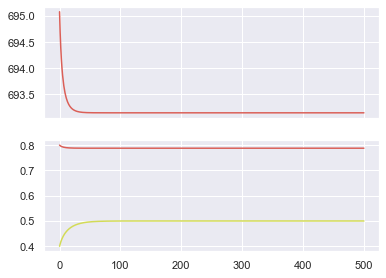

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4.5), sharex=True)
ax[0].plot(l_tracker)
ax[1].plot([t[0] for t in theta_tracker])
ax[1].plot([t[1] for t in theta_tracker])


Text(0, 0.5, 'b')

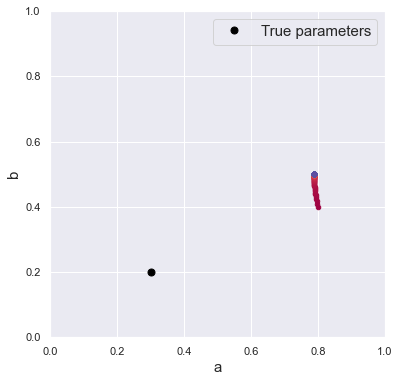

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

Pal = sns.color_palette("Spectral", len(theta_tracker))

for i, theta in enumerate(theta_tracker):
    ax.plot([theta[0]], [theta[1]], 'o', markersize=4.5, color=Pal[i])
ax.plot(a, b, 'o', color='k', markersize=7, label="True parameters")
ax.legend(fontsize=15)

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

ax.set_xlabel(r"a", fontsize=15)
ax.set_ylabel(r"b", fontsize=15)

In [17]:
# As an alternate approach, we can use a built-in optimizer from scipy
import scipy.optimize

# however, ot o that efficiently we need to redefine the objective function
def calc_likelihood_optimizer(
    param_arr: Iterable, obs_ts: Iterable, est: infer.MarkovInfer
) -> float:
    A, B = _build_hmm_parameters(param_arr)
    est.forward_algo(obs_ts, A, B)

    likelihood = 0
    for bayes, obs in zip(est.forward_tracker[1:], obs_ts):
        inner = bayes @ B[:, obs]
        likelihood -= np.log(inner)
    return likelihood

est = infer.MarkovInfer(2, 2)
A, B = _build_hmm_parameters(param_init)
est.forward_algo(obs_ts, A, B)

bnds = ([0.001, 0.99], [0.001 ,0.99])

res = scipy.optimize.minimize(calc_likelihood_optimizer, param_init, args=(obs_ts, est), method="SLSQP", bounds=bnds)

In [18]:
res

     fun: 540.3776854415497
     jac: array([ 0.03482819, -0.00585175])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([0.0425304, 0.8634803])